In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch import nn
import glob
import numpy as np
import matplotlib.pyplot as plt


torch.__version__

import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets

from torchsummary import summary
from tqdm.notebook import trange, tqdm

In [ ]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Define the transforms to apply to the images
train_transform = transforms.Compose([
    transforms.Resize(size=(28,28)),
    # transforms.Grayscale(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize(size=(28,28)),
    # transforms.Grayscale(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

# Load the training set
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/FloodNet/train', transform=train_transform)

# Create the data loader for the training set
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder('/content/drive/MyDrive/FloodNet/Test', transform=test_transform)

# Create the data loader for the training set
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
len(train_dataloader), len(test_dataloader)

(13, 13)

torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])


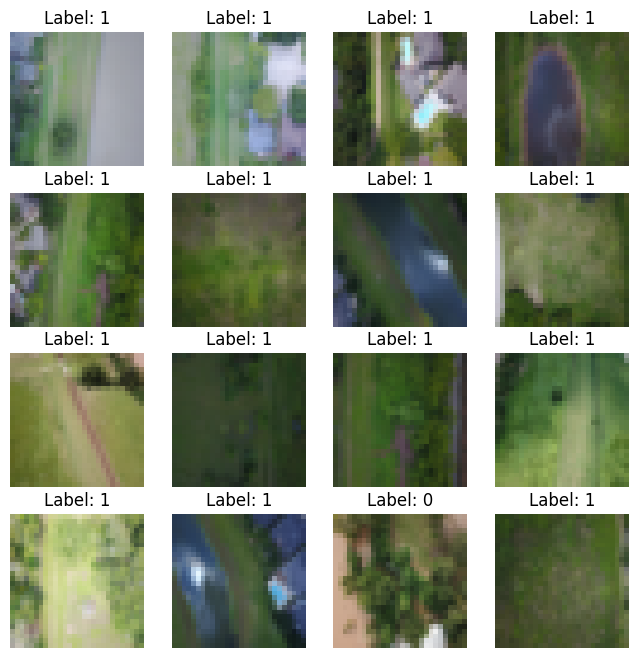

In [ ]:
data, labels = next(iter(train_dataloader))

# Plot the first 16 images in the batch
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(data[i].permute(1, 2, 0))
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
    print(data[i].shape)
plt.show()

In [ ]:
latent_dims = 10 #80
num_epochs = 20
# batch_size = 128
capacity = 32
learning_rate = 0.001
use_gpu = True

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        #26x26x32 => 13x13x32
        self.d0 = nn.MaxPool2d(2, stride = 2)
        #13x13x32 => 6x6x50
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=50, kernel_size=5, padding = 1, stride = 2)
        #6x6x50 => 2x2x50
        self.d01 = nn.AvgPool2d(3, stride = 2)
        self.d1 = nn.Linear(2 * 2* 50, 128)
        self.d2 = nn.Linear(128, 2)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)
        x = self.d0(x)
        x = self.conv2(x)
        x = self.d01(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.sigmoid(logits)
        return out

In [ ]:
## test the model with 1 batch
model = MyModel()
for images, labels in train_dataloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 3, 28, 28])
torch.Size([32, 2])


In [ ]:
learning_rate = 0.001
num_epochs = 5
BATCH_SIZE = 32

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(tqdm(train_dataloader, desc="Processing items")):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        #labels = labels.view(-1, 1).float()
        loss = criterion(logits, labels)
        print(loss)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Processing items:   0%|          | 0/13 [00:00<?, ?it/s]

tensor(0.6898, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6643, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6483, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6028, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5457, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5337, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4493, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4361, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3866, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4473, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4416, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5283, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch: 0 | Loss: 0.5829 | Train Accuracy: 90.36


Processing items:   0%|          | 0/13 [00:00<?, ?it/s]

tensor(0.4077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4386, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5008, device='cuda:0', grad_fn=<NllLossBackward0>)


KeyboardInterrupt: ignored

In [ ]:
summary(model,(3,28,28))

In [ ]:
outputs1=[]
threshold = 0.5
model.eval()

# iterate over the test dataloader and make predictions
with torch.no_grad():
 for (img, labels) in test_dataloader:
        # get the input image from the data
    img=img.to(device)
    labels = labels.to(device)
    labels = labels.view(-1, 1).float()

    recon1 = model(img)

    preds = (recon1 >= threshold).float()
    #preds = preds.squeeze().tolist()
    print(preds)



    imgi=img
    img = torch.nn.functional.interpolate(img, size=28, mode='bilinear', align_corners=False) # resizeing image to 56*56 for calculating loss

    loss1 = criterion(labels, preds)
    # make a prediction using the model
    print(f'Epoch:{epoch+1}, Loss:{loss1.item():.4f}')
    outputs1.append((epoch, imgi, recon1))